### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import gensim
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from wordcloud import WordCloud

pd.set_option("display.max_colwidth", 200)

### Helper functions

In [25]:

def get_wordcounts_df(text,stop=True):
    tokens = word_tokenize(text)
    f = FreqDist(tokens)
    words_df = pd.DataFrame({'word':list(f.keys()), 'count':list(f.values())})
    
    if(stop):
        tokens_stop = [token for token in tokens if (token not in stop_words)]
        f_stop = FreqDist(tokens_stop)
        words_df_stop = pd.DataFrame({'word':list(f_stop.keys()), 'count':list(f_stop.values())})
        return words_df,words_df_stop
    else:
        return words_df


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

def process_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

### Data Import and cleaning

In [3]:
data = pd.read_csv('train.csv',encoding = "ISO-8859-1")

In [4]:
data.drop(['ItemID'],axis=1,inplace=True)

In [5]:
data.columns = ['sentiment','tweet']

In [6]:
data.shape

(99989, 2)

In [7]:
print('Removing tags')
data['processed_tweet'] = data['tweet'].map(lambda x: re.sub("@\S+", ' ', x))

print('Lowercasing')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: x.lower())

print('Removing numbers')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: re.sub(r'\d+', ' ', x))

print('Removing links')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: re.sub("https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', x))

print('Handling Emojis')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: handle_emojis(x))


print('Removing punctuation')
data['processed_tweet']  = data['processed_tweet'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

print('Removing white spaces')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: x.strip())

print('Tokenizing')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: word_tokenize(x))
 
print('Removing non alpha tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [word for word in x if word.isalpha()])

print('Removing stop words')
stop_words = set(stopwords.words('english'))
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [w for w in x if not w in stop_words and len(w)>1])

print('processing tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [process_word(word) for word in x])

print('Lemmatization')
lem = WordNetLemmatizer()
data['processed_tweet'] = data['processed_tweet'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

print('Joining tokens')
data['processed_tweet'] = data['processed_tweet'].map(lambda x: ' '.join(x))

print('Done')

Removing tags
Lowercasing
Removing numbers
Removing links
Handling Emojis
Removing punctuation
Removing white spaces
Tokenizing
Removing non alpha tokens
Removing stop words
processing tokens
Lemmatization
Joining tokens
Done


### Inspecting the data

In [8]:
data.sample(10)

,sentiment,tweet,processed_tweet
52533,1,"@awaketoday awww, thanks",aww thank
24592,1,@2NiteBoy damn it xD hurry up,damn xd hurry
79061,1,@celiabb 8 but the next one up would be better,next one would better
89952,1,@cleeobea drink lots of water- they always help my headaches not seem so intense! and then go to bed!,drink lot water always help headaches seem intense go bed
61907,1,@biggsjm Is it a family tradition?,family tradition
99225,0,@CrazyBallerina can't. my sal wont be in until next week,sal wont next week
6736,0,#followfriday @SusieGennoe - she's only got 35 followers and that makes me so sad,followfriday get followers make sad
26170,1,@612brisbane try following my public account instead of @rocketpilot,try follow public account instead
56640,0,"@BarackObama don't act like you didn't smoke in your hayday, buster!! Don't take my flavors away",act like smoke hayday buster take flavor away
2613,0,I got scolded for not waiting and spending MORE to find my perfect storage solution... saddies Guess I should have *hangs head*,get scold wait spend find perfect storage solution saddies guess hang head


In [9]:
#Checking for null values
data.isna().sum()

sentiment          0
tweet              0
processed_tweet    0
dtype: int64

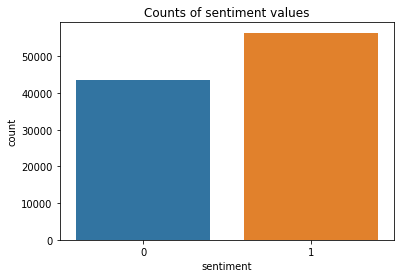

In [10]:
#Sentiment values percentage
sns.countplot(data.sentiment);
plt.title('Counts of sentiment values');

In [11]:
print('Distribution of sentiments')
data.sentiment.value_counts()*100/len(data)

Distribution of sentiments


1    56.463211
0    43.536789
Name: sentiment, dtype: float64

### Distribution of lengths

In [12]:
data['lengths'] = [len(str(t)) for t in data.tweet]

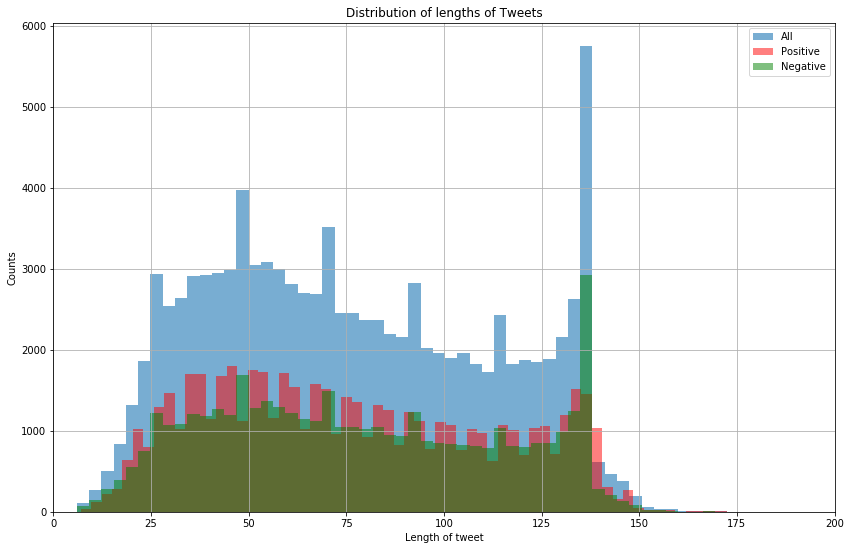

In [13]:
plt.figure(figsize=(14,9));
plt.xlim(0,200);
data.lengths.hist(density=False,bins=300,alpha=0.6,label='All');
data[data.sentiment==1].lengths.hist(density=False,bins=100,alpha=0.5,label='Positive',color='red');
data[data.sentiment==0].lengths.hist(density=False,bins=300,alpha=0.5,label='Negative',color='green');
plt.title('Distribution of lengths of Tweets')
plt.xlabel('Length of tweet')
plt.ylabel('Counts')
plt.legend();


### Inspecting negative sentiment

In [14]:
data[data.sentiment==0].sample(15,random_state=2)

,sentiment,tweet,processed_tweet,lengths
731,0,;( noooo! why? things are so complicated if I spelt that wrong idc,noo things complicate spell wrong idc,67
66061,0,@bliss_ke I did...sadness I wanna get my nose pierced I might just say fuck it and do it...lol or get another tat...idk yet,sadness wan na get nose pierce might say fuck lol get another tat idk yet,124
47358,0,@alltony no its the same day as edgefest lol TEXT ME i dont know why i dont have your number in my phone,day edgefest lol text dont know dont number phone,106
66528,0,"@blue_id_grl01 I know - very immature for people to react to ANY celeb that way, huh. Thank God he had security! He was so nice about it",know immature people react celeb way huh thank god security nice,137
24673,0,@acidcode i never even having known them...,never even know,44
6158,0,saddness let me no if i can,saddness let,28
29514,0,@acummings it was good although the $5 special is only pepperoni. Unfortunately they skimped on the sauce,good although special pepperoni unfortunately skimp sauce,106
24863,0,"@30SECONDSTOMARS wow you guys are cool for spreading the summit across the world,oh but you always forget out Scotland when you tour",wow guy cool spread summit across world oh always forget scotland tour,134
645,0,why me?,,9
425,0,Exercise 2 build muscle mass is only thing that speeds metabolism: http://tinyurl.com/bvagbj,exercise build muscle mass thing speed metabolism,94


### Inspecting positive sentiment

In [15]:
data[data.sentiment==1].sample(15,random_state=2)

,sentiment,tweet,processed_tweet,lengths
97607,1,"@CokoClemons oh, all is peachy with me! you reeeeeaaady for your releeeeeeaaase???",oh peachy reeaady releeaase,84
14808,1,"(@lovelightliz) note to self: when awed/ amazed/ etc. about something, the correct expression to utter is &quot;Fascinating!&quot;",note self awe amaze etc something correct expression utter quot fascinate quot,131
50212,1,@askaaronlee Great! I look forward to it!,great look forward,42
31984,1,@Aftashok it will move..u gotta have faith,move get ta faith,43
70752,1,@brenleigh Happy Friday to you too! I'm so ready for a long weekend,happy friday ready long weekend,70
65717,1,"@blakebillingsly Naah, not the porn bots fault and there wouldn't be foul play.... but you probably secretly clicked on one..didn't you?",naah porn bots fault foul play probably secretly click one,137
12444,1,&quot;A margarita a day makes work more like play&quot;,quot margarita day make work like play quot,56
31471,1,@AdrianDinArad succes,succes,23
92900,1,@Chrissy89 @FallOutCookGirl you know - if u didn't watch the first part it was good...I do miss him!,know watch first part good miss,101
61614,1,@Big_Frame hey its cool...everyone is welcome! When you see us discussing just join on in!,hey cool everyone welcome see us discuss join,91


### Wordclouds

In [16]:
pos_data = data[data.sentiment==1]
neg_data = data[data.sentiment==0]
pos_text = ' '.join(str(t) for t in pos_data.processed_tweet)
neg_text = ' '.join(str(t) for t in neg_data.processed_tweet)

Positive Sentiment

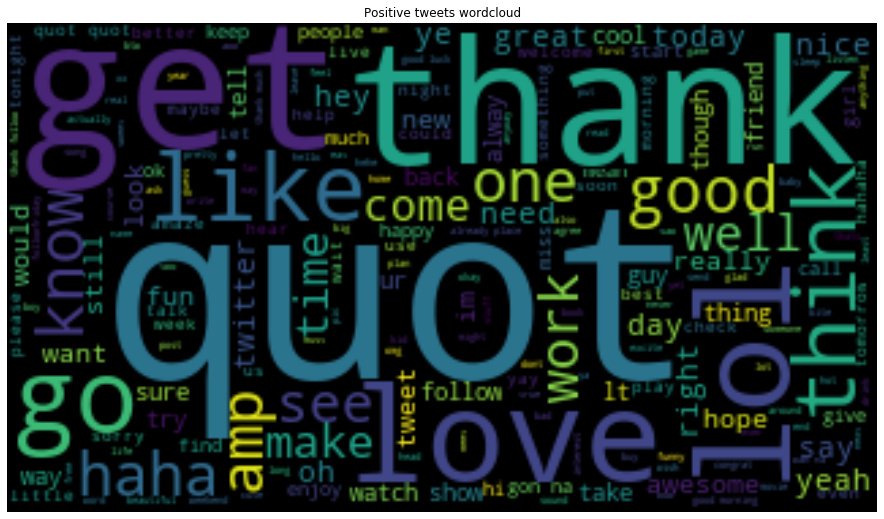

In [17]:
wc_pos = WordCloud(width=320,height=180,stopwords=stop_words).generate(pos_text)
plt.figure(figsize=(16,9))
plt.title('Positive tweets wordcloud')
plt.axis('off')
plt.imshow(wc_pos,interpolation='bilinear');

In [18]:
pos_d = get_wordcounts_df(pos_text,stop=False)

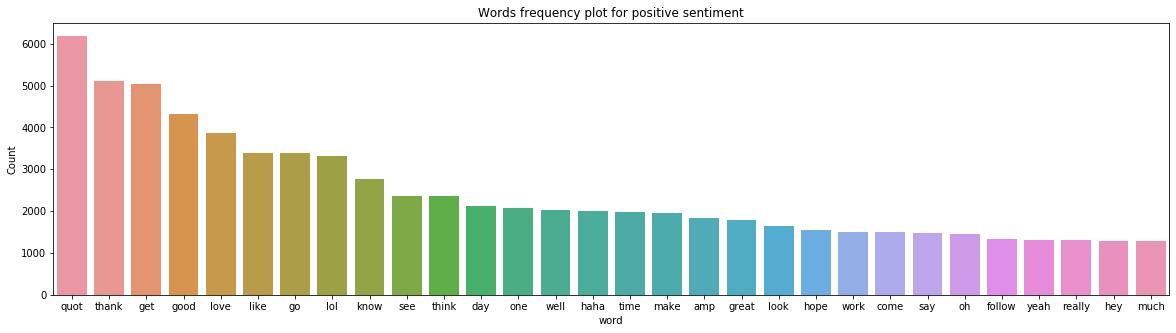

In [19]:
d = pos_d.nlargest(columns="count", n = 30) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Words frequency plot for positive sentiment')
plt.show()

### Negative Sentiment

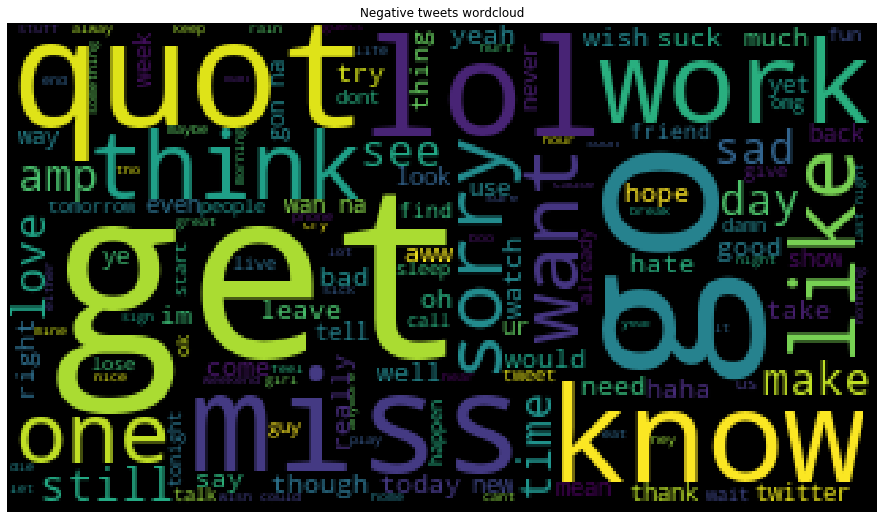

In [20]:
wc_neg = WordCloud(width=320,height=180,stopwords=stop_words).generate(neg_text)
plt.figure(figsize=(16,9))
plt.title('Negative tweets wordcloud')
plt.axis('off')
plt.imshow(wc_neg);

In [21]:
neg_d = get_wordcounts_df(neg_text,stop=False)

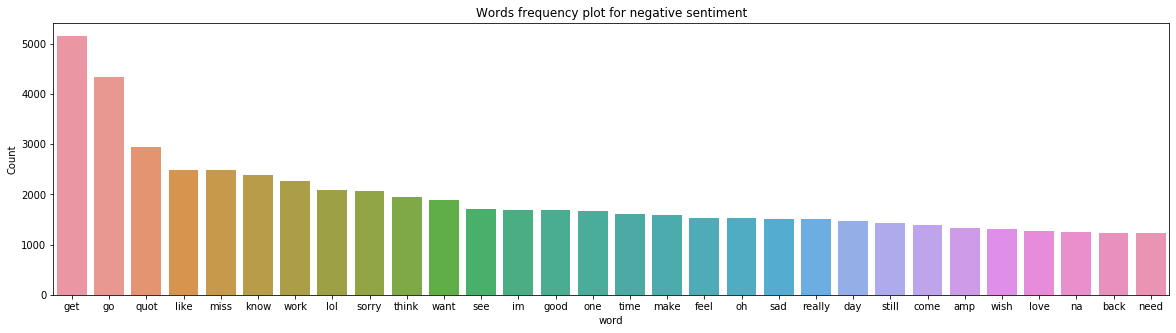

In [22]:
d = neg_d.nlargest(columns="count", n = 30) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Words frequency plot for negative sentiment')
plt.show()